# Statistical analysis of slot leadership in `peras-iosim`

This notebook is best viewed at https://nbviewer.org/.

## Load required packages

In [1]:
require(data.table)
require(ggplot2)
require(magrittr)

Loading required package: data.table

Loading required package: ggplot2

Loading required package: magrittr



## Read experimental results

The experiment was created from using the [experiment.sh](experiment.sh) script.

In [2]:
results <- fread("results.csv")
results %>% summary

      Seed       Active Slot Coefficient    End Slot     Total Stake  
 Min.   :   11   Min.   :0.05            Min.   :7200   Min.   :1000  
 1st Qu.: 8729   1st Qu.:0.05            1st Qu.:7200   1st Qu.:1000  
 Median :16728   Median :0.05            Median :7200   Median :1000  
 Mean   :16780   Mean   :0.05            Mean   :7200   Mean   :1000  
 3rd Qu.:24906   3rd Qu.:0.05            3rd Qu.:7200   3rd Qu.:1000  
 Max.   :32737   Max.   :0.05            Max.   :7200   Max.   :1000  
   Node Stake     Blocks Produced
 Min.   :   1.0   Min.   :  0.0  
 1st Qu.: 256.0   1st Qu.: 92.0  
 Median : 494.5   Median :182.0  
 Mean   : 503.6   Mean   :182.0  
 3rd Qu.: 761.5   3rd Qu.:276.2  
 Max.   :1000.0   Max.   :394.0  

### Extract the simulation parameters

In [3]:
activeSlotCoefficient <- results[1, `Active Slot Coefficient`]
activeSlotCoefficient

[1] 0.05

In [4]:
totalStake <- results[1, `Total Stake`]
totalStake

[1] 1000

In [5]:
slotCount <- results[1, `End Slot`]
slotCount

[1] 7200

## Compute the distribution of expected number of blocks produced

In [6]:
pBlock <- function(stake) {
    1 - (1 - activeSlotCoefficient)^(stake / totalStake)
}

In [7]:
probs <- CJ(
    `Node Stake`=c(1,2,5,10,20,50,100,200,500,1000),
    `Probability`=c(0.001, 0.01, 0.05, 0.95, 0.99, 0.999)
)
probs[, `Blocks Produced`:=mapply(function(s, p) qbinom(p, slotCount, pBlock(s)), `Node Stake`, `Probability`)]
probs %>% head

Node Stake,Probability,Blocks Produced
<dbl>,<dbl>,<dbl>
1,0.001,0
1,0.010,0
1,0.050,0
1,0.950,2
1,0.990,2
1,0.999,3


## Compare the experimental results to the probability contours

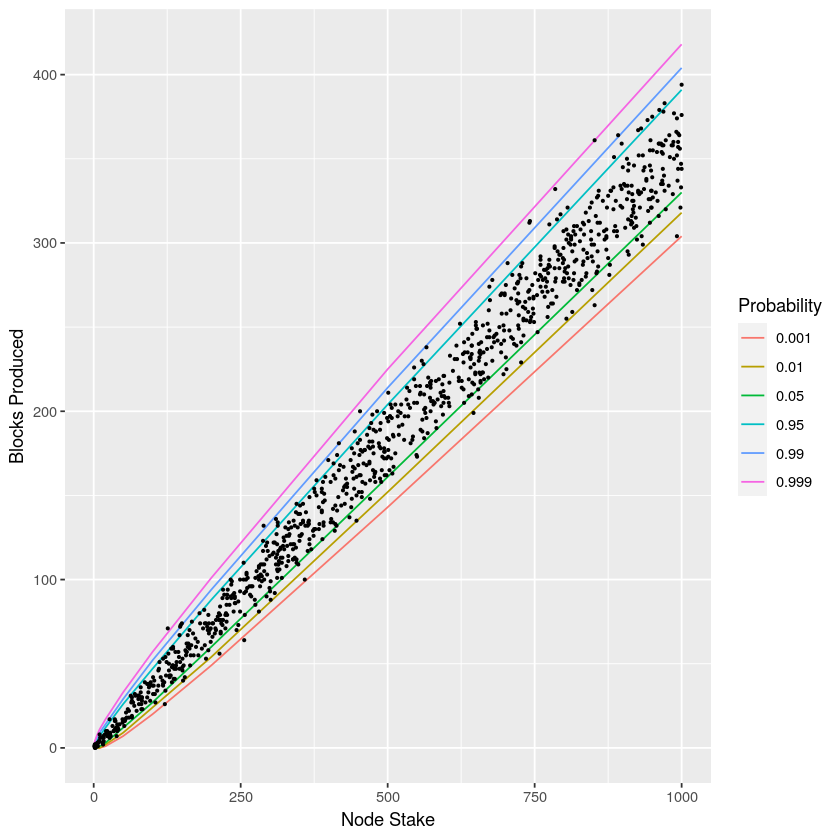

In [8]:
ggplot(probs, aes(x=`Node Stake`, y=`Blocks Produced`)) +
  geom_line(aes(group=factor(`Probability`), color=factor(`Probability`))) +
  labs(color="Probability") +
  geom_point(data=results, aes(x=`Node Stake`, y=`Blocks Produced`), size=0.5)

In [9]:
ggsave("stake-blocks.png", width=6, height=4, units="in")

## Plot the empirically observed quantiles

In [10]:
results[, `Quantile`:=mapply(function(s, q) pbinom(q, slotCount, pBlock(s)), `Node Stake`, `Blocks Produced`)]

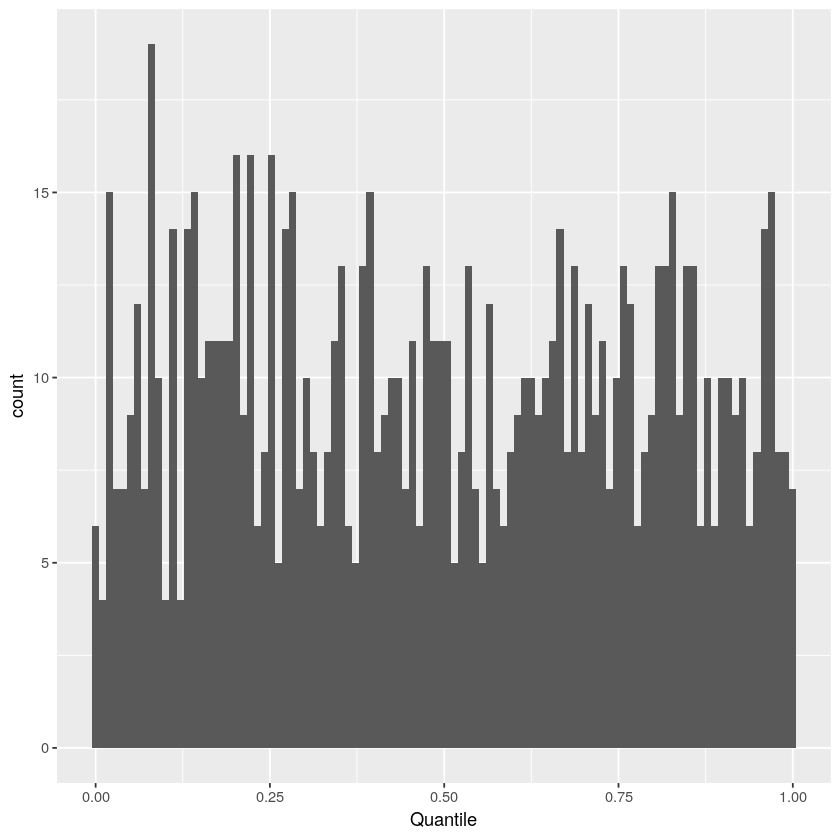

In [11]:
ggplot(results, aes(x=`Quantile`)) +
  geom_histogram(bins=100)

This looks pretty uniform, but let's quantify that.

## Perform a Kolmogorov-Smirnov test

This test checks whether the data's quantiles are uniformly distributed. If they are, then the block production count is consistent with a binomial distribution.

In [12]:
ks.test(results$`Quantile`, "punif", min=0, max=1)

Warning message in ks.test.default(results$Quantile, "punif", min = 0, max = 1):
“ties should not be present for the Kolmogorov-Smirnov test”



	Asymptotic one-sample Kolmogorov-Smirnov test

data:  results$Quantile
D = 0.023265, p-value = 0.6587
alternative hypothesis: two-sided


🙂 The *p*-value of 0.66 indicates no difference from a uniform distribution.

## How accurate is the normal approximation to this binomial distribution?

We might not want to use exact results for the binomial distribution because we need the inverse incomplete beta function for that. Can we approximate by a normal distribution?

The variance of a binomial distribution is $n p (1 - p)$.

In [13]:
p <- pBlock(500)
xmean <- slotCount * p
xsd <- sqrt(slotCount * p * (1 - p))
c(p, xmean, xsd)

[1]   0.02532057 182.30807174  13.33011359

Compute quantiles of the normal approximation.

In [14]:
xqs <- qnorm(c(0.001, 0.01, 0.05, 0.95, 0.99, 0.999), xmean, xsd)
xqs

[1] 141.1149 151.2976 160.3820 204.2342 213.3186 223.5012

Now compute the actual propabilities corresponding to those approximate quantiles.

In [15]:
pbinom(xqs, slotCount, p)

[1] 0.0007566045 0.0089599727 0.0487258868 0.9500262001 0.9890117463
[6] 0.9986403245

The 1%, 5%, 95%, and 99% levels are pretty accurate, but the 0.1% and 99.9% ones are less accurate, but still acceptable for many uses.